In [5]:
import os
import time
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.fft import fft, fftfreq # FastFourierTransform
import sys
import math
from random import randrange


import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchaudio.transforms import Spectrogram
import torchaudio
import scipy.signal as signal

import librosa
import librosa.core
import librosa.feature

import time
from tempfile import TemporaryDirectory
import os
from torchvision import transforms
import wandb
from sklearn.model_selection import train_test_split

In [6]:
LOGGING = False
bottle_neck = 16
n_frames = 3
hop = 3

if LOGGING:
    wandb.login(key = '#YOUR KEY HERE')
    run_name = f'BestConf-Train52Test2'
    wandb.init(
        # set the wandb project where this run will be logged
        project="SoundAnomalyDetection",
        name=run_name,
        # track hyperparameters and run metadata
        config={
        "learning_rate": 0.001,
        "architecture": "FC-Autoencoder",
        "epochs": 200,
        }
    )


In [7]:
# Create some custom transforms to perform high pass filtering, mel spectogram, clipping, normalization
class HighPassFilter(object):
    def __init__(self, order = 4, cutoff = 6000.0):
        self.order = order
        self.cutoff = cutoff
    
    def __call__(self, y, sr):
        
        # Normalize the frequency
        normal_cutoff = self.cutoff / (0.5 * sr)

        b, a = signal.butter(self.order, normal_cutoff, btype='high', analog=False)

        # Apply the filter
        y_hp = signal.filtfilt(b, a, y)

        return y_hp, sr
    
class LogMelSpectogram(object):
    def __init__(self,
                n_mels=64,
                n_fft=1024,
                hop_length=512,
                power=2.0):
        
        self.n_mels=n_mels
        self.n_fft=n_fft
        self.hop_length=hop_length
        self.power=power
    
    def __call__(self, y, sr):
        
        mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=self.n_fft,
                                                     hop_length=self.hop_length,
                                                     n_mels=self.n_mels,
                                                     power=self.power)
        
        # convert melspectrogram to log mel energies
        log_mel_spectrogram = 20.0 / self.power * np.log10(np.maximum(mel_spectrogram, sys.float_info.epsilon))
        return [log_mel_spectrogram]
    
class ClipLogMel(object):
    def __init__(self, perc=0.8):
        
        self.perc = perc
    
    def __call__(self, log_mel_spectrogram):
        starting_frequency = int(log_mel_spectrogram.shape[0] * self.perc)
        return [log_mel_spectrogram[starting_frequency:,:]]
    
class RandomWindow(object):
    def __init__(self, n_frames=n_frames):
        
        self.n_frames = n_frames
    
    def __call__(self, log_mel_spectrogram):
        n_vectors = log_mel_spectrogram.shape[1] - self.n_frames + 1
        t = randrange(n_vectors)
        portion = np.concatenate(log_mel_spectrogram[:, t : t + self.n_frames])
        
        return portion
    
class TWindow(object):
    def __init__(self, t, n_frames=10):
        
        self.n_frames = n_frames
        self.t = t
    
    def __call__(self, log_mel_spectrogram):
        portion = np.concatenate(log_mel_spectrogram[:, self.t : self.t + self.n_frames])
        
        return portion
    
class CustomCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, *args):
        for t in self.transforms:
            args = t(*args)
        return args

In [8]:
new_dataset = []
root_dir = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/train'

for file in os.listdir(root_dir):
    y, sr = librosa.load(os.path.join(root_dir, file), sr=None, mono=True) 
    spectogram = LogMelSpectogram()(y, sr)[0]
    
    for t in range(0, spectogram.shape[1] - n_frames, hop):
#     for t in range(0, spectogram.shape[1] - n_frames):
        new_dataset.append(TWindow(t, n_frames = n_frames)(spectogram))
    
new_root_dir = '/kaggle/input/dcase-aml/eval_data/eval_data/slider/train'
for file in os.listdir(new_root_dir):
    y, sr = librosa.load(os.path.join(new_root_dir, file), sr=None, mono=True) 
    spectogram = LogMelSpectogram()(y, sr)[0]
    
    for t in range(0, spectogram.shape[1] - n_frames, hop):
#     for t in range(0, spectogram.shape[1] - n_frames):
        new_dataset.append(TWindow(t, n_frames = n_frames)(spectogram))

train_data, valid_data = train_test_split(new_dataset, test_size = 0.2)

In [9]:
mean = np.mean(new_dataset, axis = 0)
print(mean.shape)

std = np.std(new_dataset, axis = 0)
print(std.shape)

class CustomNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, sample):
        
        normalized_data = (sample - self.mean) / self.std
        return normalized_data
my_norm = CustomNormalize(mean, std)

(192,)
(192,)


In [10]:
class NoiseDataset(Dataset):
    def __init__(self,
                vectors, 
                post_transform = None):
        
        self.root_dir = root_dir
        self.data = vectors
        
        self.total_len = len(self.data)
        self.post_transform = post_transform
    
    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
      # Gets the next image from the passed directory
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        portion = self.data[idx]
     
        portion = self.post_transform(portion)
            
        return portion
    
train_dataset = NoiseDataset(train_data, my_norm)
valid_dataset = NoiseDataset(valid_data, my_norm)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 512, shuffle=True)

print(f'{len(train_dataloader)} batches for train set')
print(f'{len(valid_dataloader)} batches for valid set')

771 batches for train set
193 batches for valid set


# AutoEconder Baseline

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, criterion = nn.MSELoss(reduction = 'none')):
        super(AutoEncoder, self).__init__()
        self.criterion = criterion
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, bottle_neck),
            nn.BatchNorm1d(bottle_neck),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(bottle_neck, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def reconstruction_error(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return self.criterion(x, decoded)
    
    def z(self, x):
        encoded = self.encoder(x)

        decoded = self.decoder(encoded)
        loss = self.criterion(x, decoded)
        
        return torch.cat((encoded, torch.sum(loss, dim = 1, keepdim=True)), dim=1)

input_dim = 64 * n_frames

In [13]:
mkdir /kaggle/weights

In [18]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve

best_model_params_path = '/kaggle/weights/best_params.pt'

def train(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    losses = {
        'train': [],
        'valid': []
    }
    
    torch.save(model.state_dict(), best_model_params_path)
    best_loss = None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for samples in dataloaders[phase]:
                samples = samples.to(device, dtype=torch.float)
                       
                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(samples)

                    loss = criterion(outputs, samples)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            losses[phase].append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f}')

            if(LOGGING):
                if phase == 'train':
                    wandb.log({'train_loss':epoch_loss})
                else:
                    wandb.log({'valid_loss':epoch_loss})


            # deep copy the model
            if phase == 'train' and (best_loss is None or epoch_loss <= best_loss):
                best_loss = epoch_loss
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best train Loss: {best_loss:4f}')
    if(LOGGING):
        wandb.log({'best_train_loss': best_loss})

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, losses

In [19]:
#Train the encoder
TRAIN = True
device = torch.device('cuda')
model = AutoEncoder(input_dim = input_dim).to(device)

if TRAIN:
    LEARNING_RATE = 1e-3
    EPOCHS = 50
    criterion = nn.MSELoss(reduction = 'sum')
    
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    dataloaders = {'train':train_dataloader, 'valid':valid_dataloader}
    dataset_sizes = {'train': len(train_data), 'valid':len(valid_data)}

    model, losses = train(model, criterion, optimizer, exp_lr_scheduler, EPOCHS)
else:
    model.load_state_dict(torch.load(best_model_params_path))

Epoch 0/49
----------
train Loss: 66.0445
valid Loss: 55.2156

Epoch 1/49
----------
train Loss: 53.6074
valid Loss: 51.6187

Epoch 2/49
----------
train Loss: 51.0825
valid Loss: 49.5138

Epoch 3/49
----------
train Loss: 49.5181
valid Loss: 48.7062

Epoch 4/49
----------
train Loss: 48.2952
valid Loss: 48.0614

Epoch 5/49
----------
train Loss: 47.3943
valid Loss: 46.8147

Epoch 6/49
----------
train Loss: 46.4332
valid Loss: 45.7252

Epoch 7/49
----------
train Loss: 45.6977
valid Loss: 45.3731

Epoch 8/49
----------
train Loss: 45.7557
valid Loss: 45.0495

Epoch 9/49
----------
train Loss: 45.1600
valid Loss: 44.6608

Epoch 10/49
----------
train Loss: 44.8311
valid Loss: 44.2771

Epoch 11/49
----------
train Loss: 44.5790
valid Loss: 44.1157

Epoch 12/49
----------
train Loss: 44.3576
valid Loss: 44.0741

Epoch 13/49
----------
train Loss: 44.2087
valid Loss: 43.9831

Epoch 14/49
----------
train Loss: 44.0830
valid Loss: 43.5004

Epoch 15/49
----------
train Loss: 43.9360
valid L

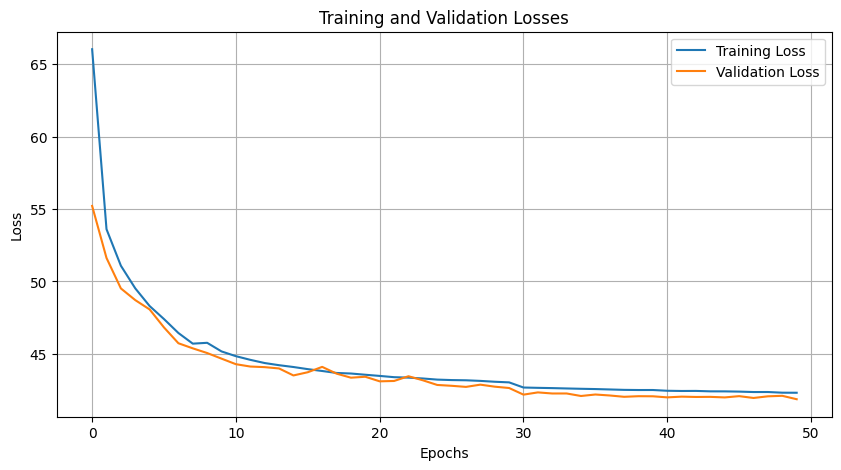

In [20]:
import matplotlib.pyplot as plt

# Example data
# losses = {'train': [0.8, 0.6, 0.4, 0.3, 0.2], 'valid': [0.9, 0.7, 0.5, 0.35, 0.25]}

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['valid'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
test_dataset = []
root_dir = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/test'

for file in os.listdir(root_dir):
    if 'id_04' not in file:
        continue
    label = 0 if 'normal' in file else 1
    
    y, sr = librosa.load(os.path.join(root_dir, file), sr=None, mono=True) 
    spectogram = LogMelSpectogram()(y, sr)[0]
    
    current_vectors = []
    for t in range(0, spectogram.shape[1] - n_frames):
        current_vectors.append(my_norm(TWindow(t, n_frames = n_frames)(spectogram)))

    test_dataset.append((label, torch.from_numpy(np.array(current_vectors))))

In [22]:
model.eval()
cumulative_labels = []
cumulative_scores = []

for label, vectors in test_dataset:

    scores = model.reconstruction_error(vectors.float().to(device))
    cum_scores = torch.sum(scores.cpu().detach(), dim=1)
    
    cumulative_labels.append(label)
    # Score is found by averaging reconstruction error of all windows
    cumulative_scores.append(np.mean(cum_scores.numpy()))

In [23]:
from sklearn.metrics import roc_auc_score

labels = np.array(cumulative_labels)
scores = np.array(cumulative_scores)

avg_normal = np.mean(scores[labels==0])
print(f'Average reconstruction error for normal samples is: {avg_normal}')
if(LOGGING):
    wandb.log({'avg_reconstruction_normal': avg_normal})

avg_anomaly = np.mean(scores[labels==1])
print(f'Average reconstruction error for anomaly samples is: {avg_anomaly}')
if(LOGGING):
    wandb.log({'avg_reconstruction_anomaly': avg_anomaly})

auc = roc_auc_score(labels, scores)
print(f'The auc score on the test is: {auc}')
if(LOGGING):
    wandb.log({'auc': auc})


Average reconstruction error for normal samples is: 47.480411529541016
Average reconstruction error for anomaly samples is: 61.963802337646484
The auc score on the test is: 0.9483707865168538


In [24]:
if(LOGGING):
    wandb.finish()

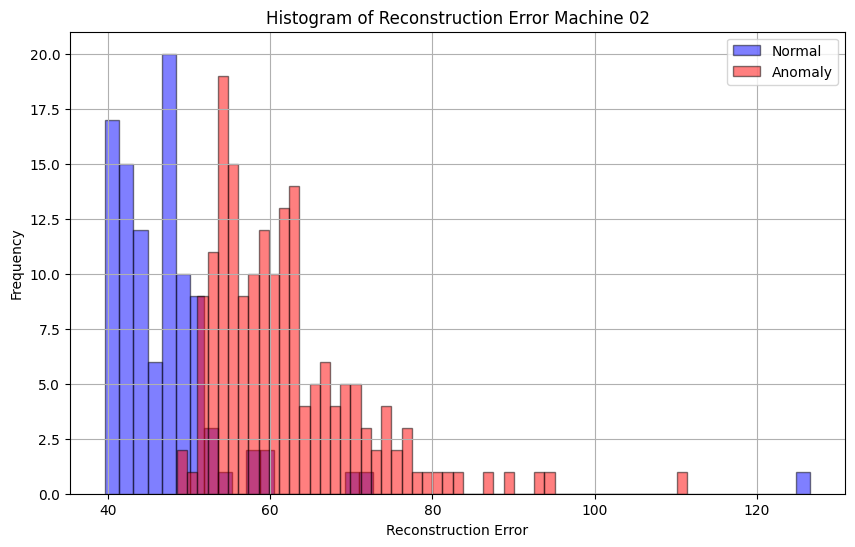

In [26]:
# Plot histograms with reconstruction error
# Higher reconstruction for anomalies
plt.figure(figsize=(10, 6))
plt.hist(scores[labels==0], bins=50, alpha=0.5, label='Normal', color='blue', edgecolor='black')
plt.hist(scores[labels==1], bins=50, alpha=0.5, label='Anomaly', color='red', edgecolor='black')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Error Machine 02')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()